In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, SpatialDropout1D, Bidirectional, LSTM, GRU, Dense, Dropout,
                                     BatchNormalization, Conv1D, MaxPooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Load data
df = pd.read_csv('Sentiment_analysis_dataset.csv')
df.dropna(subset=['Statement'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Clean augmentation (minority only)
target_count = 8000
class_counts = df['Status'].value_counts()
df_adjusted = pd.DataFrame()
augmented_samples = []

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', str(text)).lower().split()
    return ' '.join([lemmatizer.lemmatize(word) for word in text if word not in stop_words])

def get_synonyms(word):
    return list({lemma.name().replace("_", " ") for syn in wordnet.synsets(word) for lemma in syn.lemmas()
                 if lemma.name().lower() != word.lower()})

def synonym_augmentation(text, p=0.1):
    words = word_tokenize(text)
    return ' '.join([random.choice(get_synonyms(w)) if random.random() < p and get_synonyms(w) else w for w in words])

def augment_texts(text, num_aug=1, p=0.1):
    return [synonym_augmentation(text, p=p) for _ in range(num_aug)]

for cls, count in class_counts.items():
    subset = df[df['Status'] == cls]
    if count > target_count:
        subset = subset.sample(n=target_count, random_state=42)
    elif count < target_count:
        needed = target_count - count
        aug_per_row = needed // count
        remainder = needed % count
        for _, row in subset.iterrows():
            for aug_text in augment_texts(row['Statement'], aug_per_row):
                new_row = row.copy()
                new_row['Statement'] = aug_text
                augmented_samples.append(new_row)
            if remainder > 0:
                remainder -= 1
                new_row = row.copy()
                new_row['Statement'] = augment_texts(row['Statement'], 1)[0]
                augmented_samples.append(new_row)
    df_adjusted = pd.concat([df_adjusted, subset], ignore_index=True)

if augmented_samples:
    df_adjusted = pd.concat([df_adjusted, pd.DataFrame(augmented_samples)], ignore_index=True)

df_adjusted = df_adjusted.sample(frac=1, random_state=42).reset_index(drop=True)
df_adjusted['Statement'] = df_adjusted['Statement'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Split
X_train, X_test, y_train, y_test = train_test_split(df_adjusted['Statement'], df_adjusted['Status'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Tokenize
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
max_len = 200

train_pad = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post')
val_pad = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_len, padding='post')
test_pad = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')

# ✅ Label Encode
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

train_labels = label_encoder.transform(y_train)
val_labels = label_encoder.transform(y_val)
test_labels = label_encoder.transform(y_test)

# ✅ One-hot encode
from tensorflow.keras.utils import to_categorical
num_classes = len(label_encoder.classes_)

train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

# Vocab size
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300

# GloVe
!wget -nc http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q -n glove.6B.zip -d glove

embedding_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



--2025-04-08 22:06:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-08 22:06:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-08 22:06:55--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout, Dense, LayerNormalization, Add, Layer, BatchNormalization
from tensorflow.keras.layers import MultiHeadAttention, GaussianNoise
from tensorflow.keras.regularizers import L2
from keras.optimizers import AdamW

# Custom Attention Pooling
class AttentionPooling(Layer):
    def __init__(self, units):
        super().__init__()
        self.W = Dense(units, activation='tanh')
        self.V = Dense(1)

    def call(self, features):
        score = self.V(self.W(features))
        weights = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(weights * features, axis=1)

# Positional Embedding
class PositionalEmbedding(Layer):
    def __init__(self, vocab_size, embed_dim, maxlen):
        super().__init__()
        self.token_embed = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_embed = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        length = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        return self.token_embed(x) + self.pos_embed(positions)

# Hyperparameters
embed_dim = 300
maxlen = 200
num_heads = 4
ff_dim = 128

# Input
inputs = Input(shape=(maxlen,))

# Embedding + Gaussian noise
x = PositionalEmbedding(vocab_size=vocab_size, embed_dim=embed_dim, maxlen=maxlen)(inputs)
x = GaussianNoise(0.1)(x)
x = Dropout(0.3)(x)

# Multi-Head Attention
attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
attn = Dropout(0.3)(attn)
x = Add()([x, attn])
x = LayerNormalization(epsilon=1e-6)(x)

# Feedforward
ff = Dense(ff_dim, activation="relu", kernel_regularizer=L2(0.02))(x)
ff = Dropout(0.4)(ff)
ff = Dense(embed_dim, kernel_regularizer=L2(0.02))(ff)
x = Add()([x, ff])
x = LayerNormalization(epsilon=1e-6)(x)

# Attention Pooling
x = AttentionPooling(units=128)(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=L2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Build model
model = Model(inputs, outputs)

model.compile(
    optimizer=AdamW(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train model
history = model.fit(
    train_pad, train_labels,
    validation_data=(val_pad, val_labels),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - accuracy: 0.1976 - loss: 11.7524 - val_accuracy: 0.5589 - val_loss: 7.5063 - learning_rate: 1.0000e-04
Epoch 2/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 73s 40ms/step - accuracy: 0.4688 - loss: 6.4961 - val_accuracy: 0.6038 - val_loss: 4.9298 - learning_rate: 1.0000e-04
Epoch 3/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.6317 - loss: 3.5201 - val_accuracy: 0.7140 - val_loss: 2.7510 - learning_rate: 1.0000e-04
Epoch 4/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.7022 - loss: 2.0261 - val_accuracy: 0.7751 - val_loss: 1.8117 - learning_rate: 1.0000e-04
Epoch 5/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 83s 43ms/step - accuracy: 0.7427 - loss: 1.3957 - val_accuracy: 0.7924 - val_loss: 1.5081 - learning_rate: 1.0000e-04
Epoch 6/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.7706 - loss: 1.1352 - val_accuracy: 0.8090 - val_loss: 1.3324 - learning_rate: 1.0000e-04
Epoch 7/30
1050/1050 ━━━━━━━━━━━━━━━━━━

350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8574 - loss: 0.8584

✅ Test Accuracy: 0.8625
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.91      0.93      0.92      1592
             Bipolar       0.95      0.95      0.95      1552
          Depression       0.68      0.64      0.66      1598
              Normal       0.93      0.87      0.90      1614
Personality disorder       0.97      0.98      0.98      1663
              Stress       0.88      0.92      0.90      1628
            Suicidal       0.69      0.74      0.71      1553

            accuracy                           0.86     11200
           macro avg       0.86      0.86      0.86     11200
        weighted avg       0.86      0.86      0.86     11200



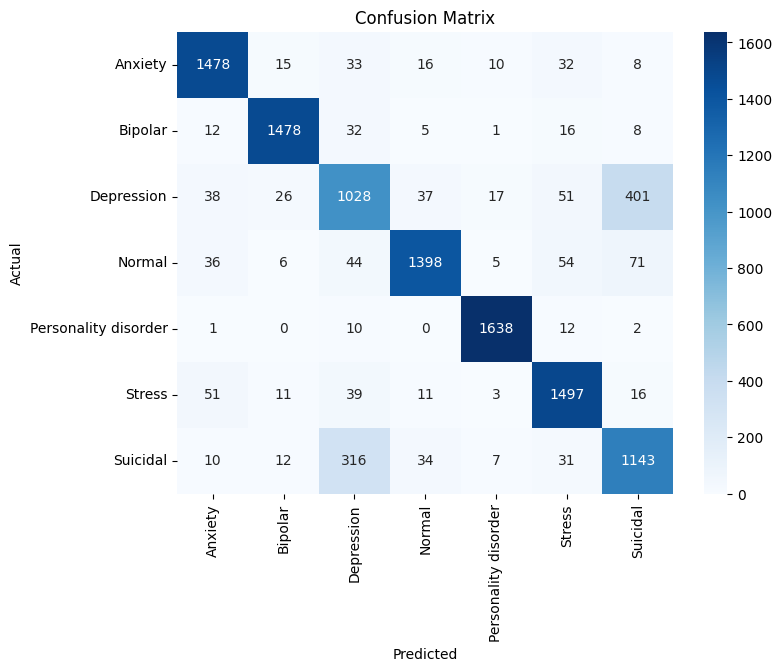

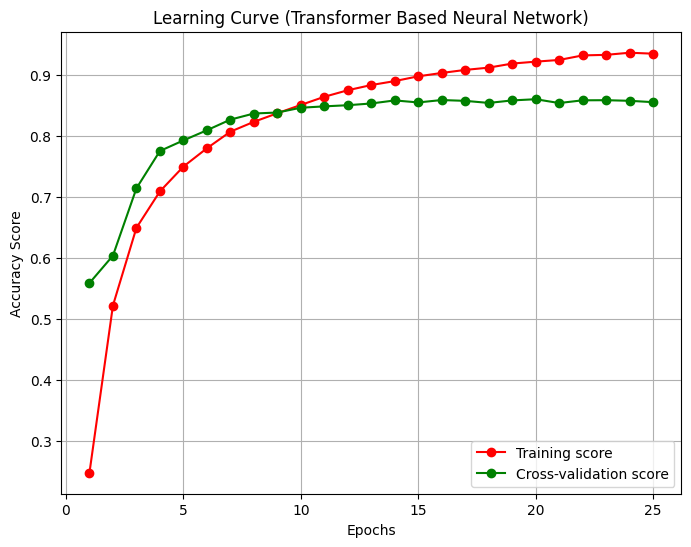

In [7]:
loss, accuracy = model.evaluate(test_pad, test_labels)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

y_pred_probs = model.predict(test_pad)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
true_classes = np.argmax(test_labels, axis=1)  # ✅ fix for one-hot

print("\nClassification Report:")
print(classification_report(true_classes, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Plot learning curve using history from model.fit()
epochs = range(1, len(history.history['accuracy']) + 1)
train_scores = history.history['accuracy']
val_scores = history.history['val_accuracy']

plt.figure(figsize=(8,6))
plt.plot(epochs, train_scores, 'o-r', label='Training score')
plt.plot(epochs, val_scores, 'o-g', label='Cross-validation score')
plt.title('Learning Curve (Transformer Based Neural Network)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





In [5]:
import pickle

# Save tokenizer and max_len
preprocessing_data = {
    'tokenizer': tokenizer,
    'max_len': max_len
}
with open('preprocessing.pkl', 'wb') as f:
    pickle.dump(preprocessing_data, f)

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save the trained model using SavedModel format
model.save('sentiment_model.h5')

In [ ]:
# Load tokenizer and max_len
with open('preprocessing.pkl', 'rb') as f:
    preprocessing_data = pickle.load(f)
tokenizer = preprocessing_data['tokenizer']
max_len = preprocessing_data['max_len']

# Load label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Load the trained model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Embedding # Import necessary classes

# Define custom layers
class AttentionPooling(Layer): # Defining the custom layer inside the loading script
    def __init__(self, units, **kwargs): # Added **kwargs
        super().__init__(**kwargs) # Pass **kwargs to super().__init__
        self.W = Dense(units, activation='tanh')
        self.V = Dense(1)

    def call(self, features):
        score = self.V(self.W(features))
        weights = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(weights * features, axis=1)

class PositionalEmbedding(Layer): # Defining the custom layer inside the loading script
    def __init__(self, vocab_size, embed_dim, maxlen, **kwargs): # Added **kwargs to accept extra arguments
        super().__init__(**kwargs) # Pass extra arguments to super().__init__
        self.token_embed = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_embed = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        length = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        return self.token_embed(x) + self.pos_embed(positions)

# Load the model with custom_objects
model = load_model('sentiment_model.h5', custom_objects={'PositionalEmbedding': PositionalEmbedding, 'AttentionPooling': AttentionPooling})

# Example usage
# sample_text = ["This is a great product!"]
# sample_sequence = tokenizer.texts_to_sequences(sample_text)
# sample_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_sequence, maxlen=max_len, padding='post')

# # Predict
# prediction = model.predict(sample_padded)
# predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
# print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: ['Normal']
